In [73]:
import numpy as np
import pickle

In [74]:
from pathlib import Path
from abc import ABC, abstractmethod

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import matplotlib.pyplot as plt

from cc_hardware.utils.manager import Manager
from cc_hardware.utils.file_handlers import PklReader
from cc_hardware.utils import register_cli, run_cli
from cc_hardware.utils import get_logger

# from model import RegressionModel, RegressionModelSeparate

In [ ]:
class HistogramDataset(Dataset):
    def __init__(self, pkl_path: Path = None, predict_magnitude: bool = False, rolling_window=5, merge: bool = False):
        if pkl_path is None:
            self.data = []
            self.inputs = []
            self.targets = []
            return

        self.data = PklReader.load_all(pkl_path)
        inputs = dict(
            histogram=[],
            position=[],
        )
        # print(type(self.data))
        for d in self.data:
            # print(type(d))
            # print(d.keys())
            # print(d)
            if "has_masks" in d and not d["has_masks"]:
                d["position"] = [0, 0, 0]
                print("mask continue")
                continue
            if "histogram" not in d or "position" not in d:
                print("hist continue")
                continue
            inputs["histogram"].append(torch.tensor(d["histogram"]))
            
            pos = d["position"]
            # print(f"position: {pos}")
            inputs["position"].append(torch.tensor((pos["x"], pos["y"])))
            # print(f"inputs: {inputs}")
            # raise Exception("exit")
        # print(inputs['position'])
        # print(f"original targets shape: {torch.stack(inputs['position']).shape}")
        
        if len(inputs["histogram"][0].shape) == 2:
            # single capture per location
            # reading input as list of location samples: (pixels, bins)
            # reading targets as list of location samples: ((x, y) position)
            self.raw_inputs = torch.stack(inputs["histogram"]).float()
            num_samples = self.raw_inputs.shape[0]
            width = np.sqrt(self.raw_inputs.shape[1]).astype(int)
            height = width
            bins = self.raw_inputs.shape[2]
            self.raw_inputs = torch.reshape(self.raw_inputs, (num_samples, width, height, bins))
            self.raw_targets = torch.stack(inputs["position"]).float()
        elif len(inputs["histogram"][0].shape) == 3:
            # multiple captures per location:
            # reading input as list of location samples: (captures per location, pixels, bins)
            # reading targets as list of location samples: ((x, y) position)
            self.raw_inputs = torch.stack(inputs["histogram"]).float()  # (locations, captures, pixels, bins)
            samples_per_location = inputs["histogram"][0].shape[0]
            # print(f"samples per location: {samples_per_location}")
            # print(f"raw shape: {self.raw_inputs.shape}")
            if rolling_window is not None:
                sliding_mean = np.array(
                    [self.raw_inputs[:, j - rolling_window + 1: j + 1, :, :].mean(axis=1)
                        for j in range(rolling_window - 1, samples_per_location)
                    ]).swapaxes(0, 1)
                # print(f"sliding mean shape: {sliding_mean.shape}")
                self.raw_inputs = torch.tensor(sliding_mean)
            samples_per_location = self.raw_inputs.shape[1]
            # print(f"samples_per_location: {samples_per_location}")
            # print(f"shape: {self.raw_inputs.shape}")
            self.raw_inputs = torch.reshape(self.raw_inputs, 
                (self.raw_inputs.shape[0] * self.raw_inputs.shape[1], self.raw_inputs.shape[2], self.raw_inputs.shape[3]))
            # self.raw_inputs = torch.concat(inputs["histogram"], dim=0).float()  # (all captures, pixels, bins)
            num_samples = self.raw_inputs.shape[0]
            width = np.sqrt(self.raw_inputs.shape[1]).astype(int)
            height = width
            bins = self.raw_inputs.shape[2]
            self.raw_inputs = torch.reshape(self.raw_inputs, (num_samples, width, height, bins))
            self.raw_targets = torch.stack(inputs["position"], dim=0).float()  # (location samples, (x, y) position)
            self.raw_targets = torch.repeat_interleave(self.raw_targets, samples_per_location, dim=0)

        # raw_inputs: (all captures, width, height, bins)
        # raw_targets: (all captures, (x, y) position)

        self.START_BIN = 0
        self.END_BIN = bins
        self.inputs = self.raw_inputs
        self.targets = self.raw_targets

        if predict_magnitude:
            self.targets = torch.linalg.norm(self.targets, dim=1, keepdim=True)

        if merge:
            self.inputs = self.inputs.sum(dim=(1), keepdim=True)

    def set_start_bin(self, start_bin: int):
        self.START_BIN = start_bin
        self.inputs = self.raw_inputs[:, :, :, self.START_BIN:self.END_BIN]

    def set_end_bin(self, end_bin: int):
        self.END_BIN = end_bin
        self.inputs = self.raw_inputs[:, :, :, self.START_BIN:self.END_BIN]

    def get_raw_bin_num(self):
        return self.raw_inputs.shape[3]

    def get_bin_num(self):
        return self.inputs.shape[3]

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]
    
    def __add__(self, other):
        combined_dataset = HistogramDataset()
        combined_dataset.raw_inputs = torch.cat((self.raw_inputs, other.raw_inputs), dim=0)
        combined_dataset.raw_targets = torch.cat((self.raw_targets, other.raw_targets), dim=0)
        combined_dataset.START_BIN = self.START_BIN
        combined_dataset.END_BIN = self.END_BIN
        combined_dataset.inputs = combined_dataset.raw_inputs[:, :, :, self.START_BIN:self.END_BIN]
        combined_dataset.targets = combined_dataset.raw_targets
        return combined_dataset


In [76]:
pkl_path = "../../datasets/robotics/localization/10x10_samples/capture_vest.pkl"

In [77]:
dataset = HistogramDataset(
    pkl_path,
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
all_loader = DataLoader(dataset, batch_size=batch_size)

In [78]:
dataset.inputs.shape

torch.Size([1000, 4, 4, 48])

In [79]:
dataset.targets.shape

torch.Size([1000, 4, 4, 48])

In [80]:
len(dataset)

1000

In [81]:
mini_sample =dataset.inputs[1, :, :, :]

In [82]:
mini_sample.shape

torch.Size([4, 4, 48])

In [83]:
equal_part = (mini_sample[18, :, :] == mini_sample[17, :, :])

IndexError: index 18 is out of bounds for dimension 0 with size 4

In [84]:
equal_part.shape

NameError: name 'equal_part' is not defined

In [85]:
16 * 48

768

In [86]:
# get total number of equal parts
equal_part.sum()

NameError: name 'equal_part' is not defined

In [87]:
dataset.raw_inputs.shape

torch.Size([1000, 4, 4, 48])

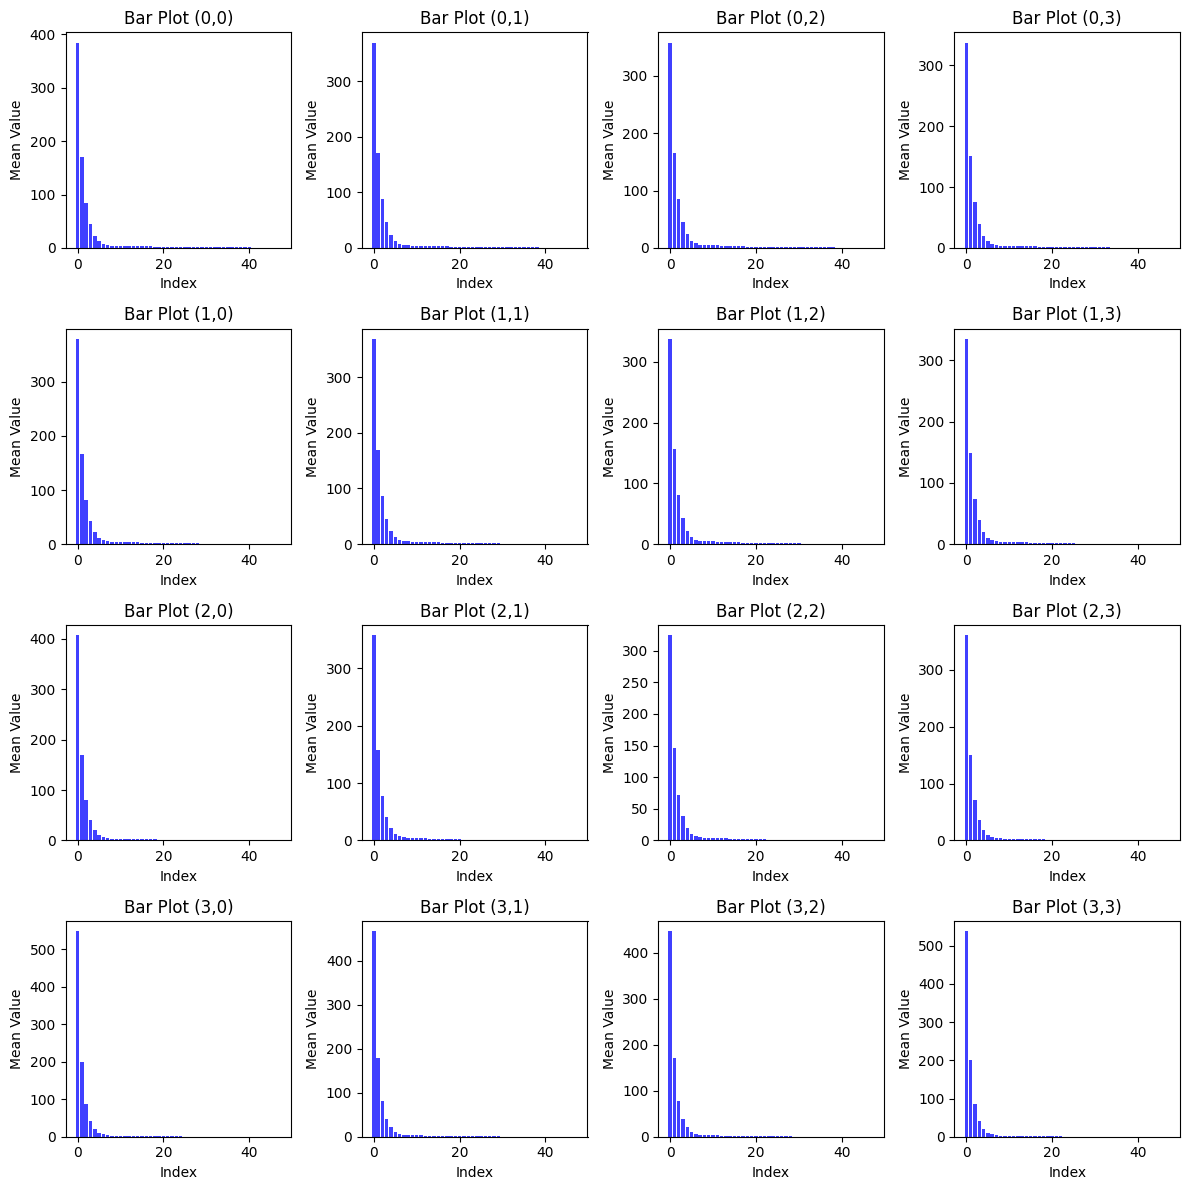

In [88]:
# Compute mean over the first dimension (n)
mean_tensor = dataset.raw_inputs.mean(dim=0)  # Shape becomes [4, 4, 48]

# Create a 4x4 grid of bar plots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

x = np.arange(48)  # x-axis positions for the 48 bars

for i in range(4):
    for j in range(4):
        axes[i, j].bar(x, mean_tensor[i, j].numpy(), color='b', alpha=0.75)
        axes[i, j].set_title(f"Bar Plot ({i},{j})")
        axes[i, j].set_xlabel("Index")
        axes[i, j].set_ylabel("Mean Value")
        # axes[i, j].set_yscale('log')

plt.tight_layout()
plt.show()

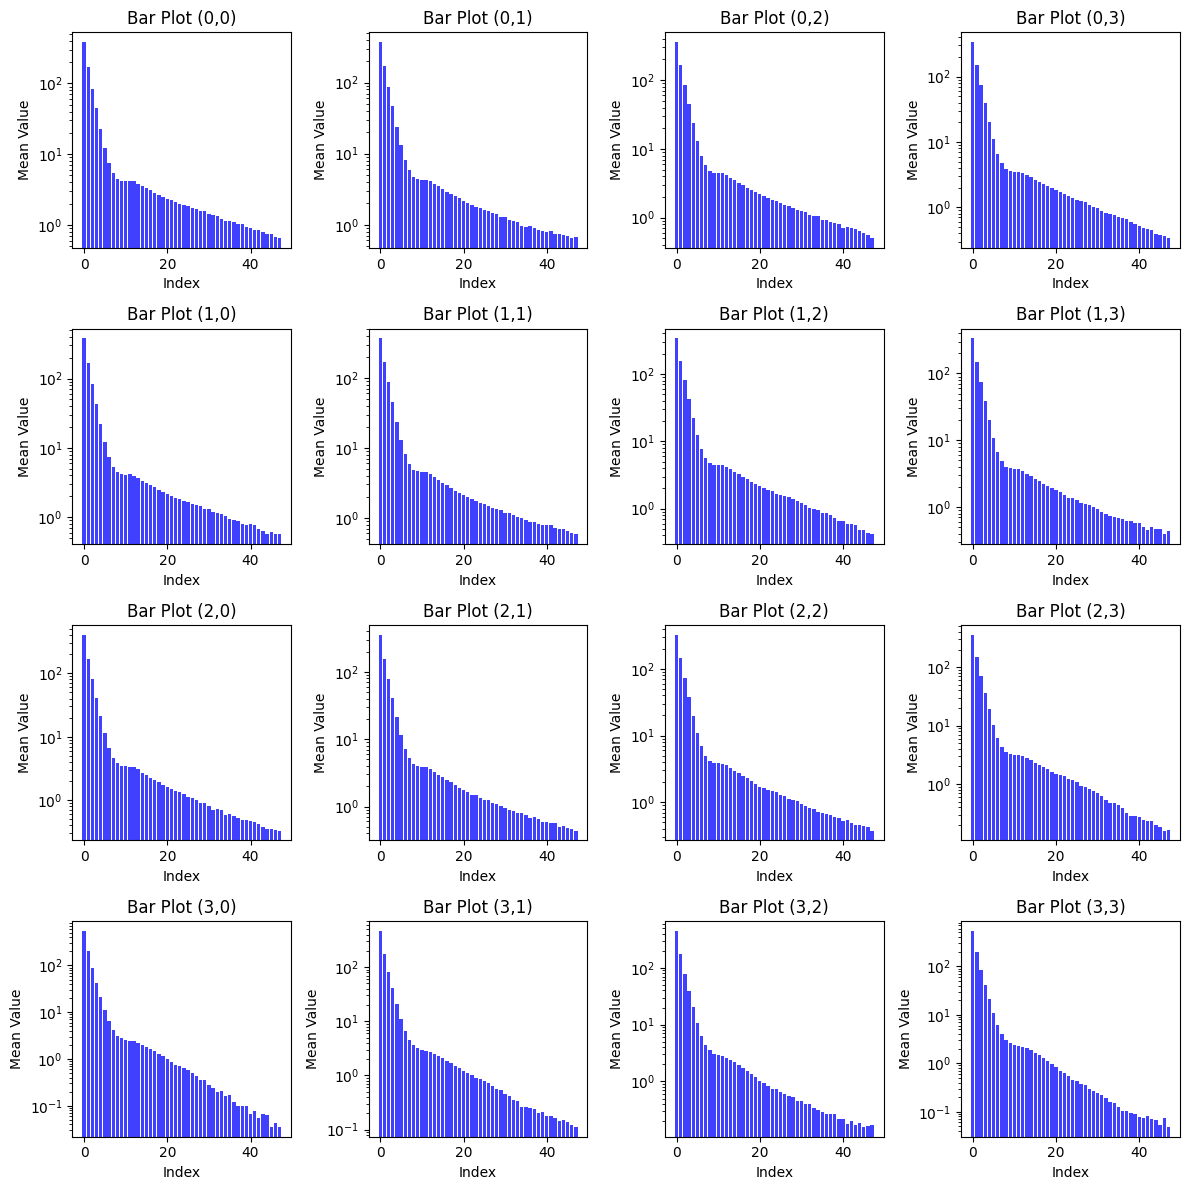

In [89]:
# Compute mean over the first dimension (n)
mean_tensor = dataset.raw_inputs[:, :, :, :].mean(dim=0)  # Shape becomes [4, 4, 48]

# Create a 4x4 grid of bar plots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

x = np.arange(48)  # x-axis positions for the 48 bars

for i in range(4):
    for j in range(4):
        axes[i, j].bar(x, mean_tensor[i, j].numpy(), color='b', alpha=0.75)
        axes[i, j].set_title(f"Bar Plot ({i},{j})")
        axes[i, j].set_xlabel("Index")
        axes[i, j].set_ylabel("Mean Value")
        axes[i, j].set_yscale('log')

plt.tight_layout()
plt.show()

Mask shape: torch.Size([1000])
Number of points inside: 10
Masked inputs shape: torch.Size([10, 4, 4, 48])


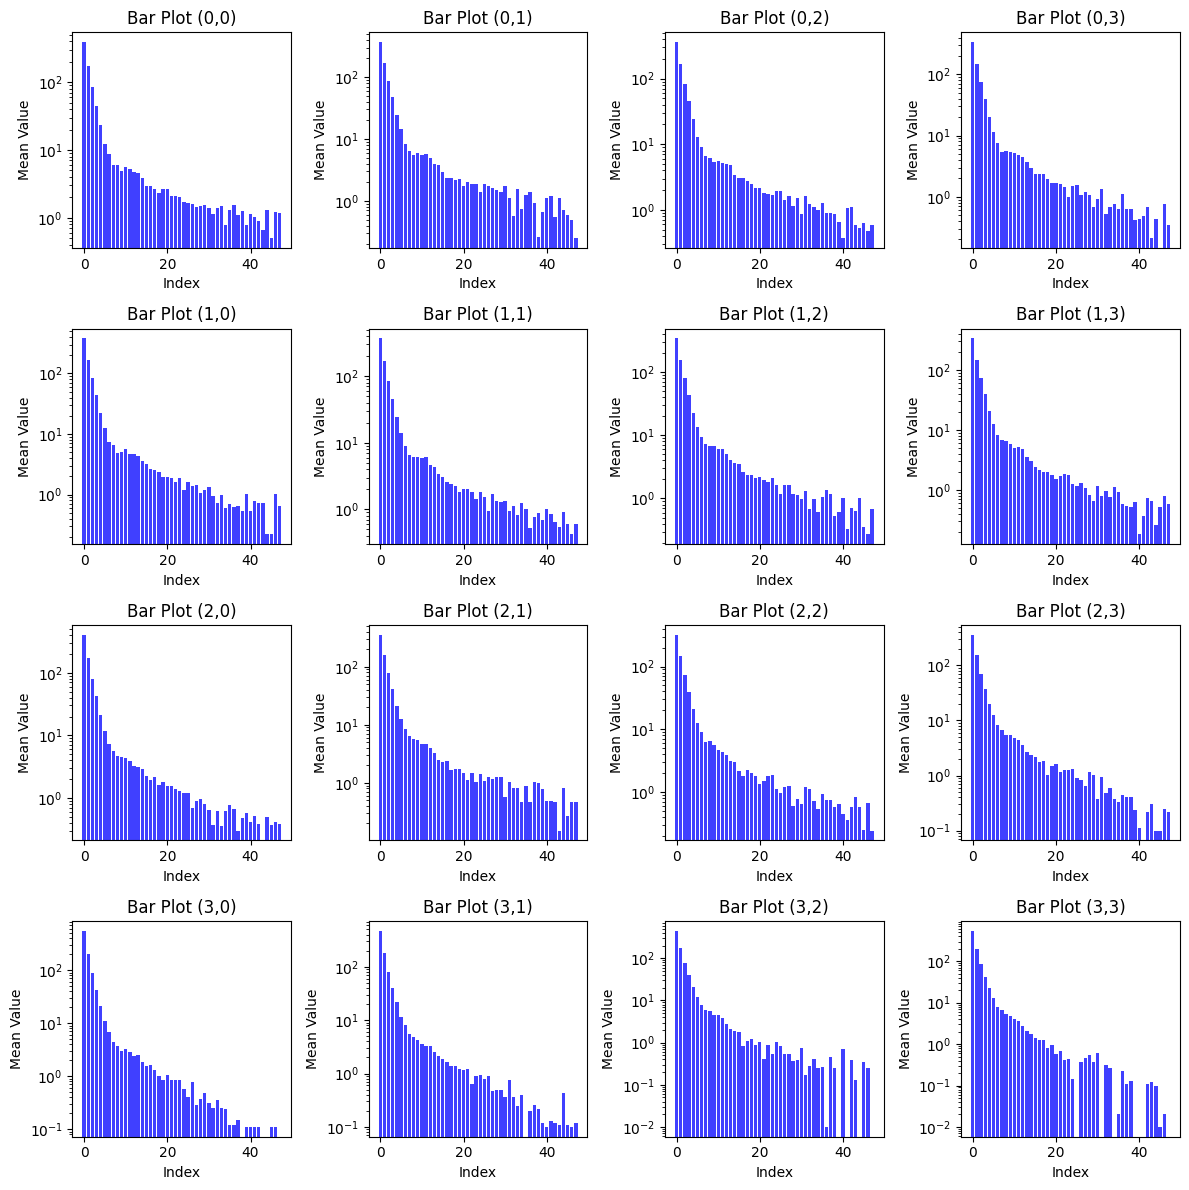

In [90]:
# Define rectangular bounds: (x_min, x_max, y_min, y_max)
x_min, x_max = -0.5, 0.5
y_min, y_max = -0.5, 0.5

# Create mask: True where (x, y) is inside the rectangle
mask_1 = (dataset.raw_targets[:, 0] >= x_min) & (dataset.raw_targets[:, 0] <= x_max) & \
       (dataset.raw_targets[:, 1] >= y_min) & (dataset.raw_targets[:, 1] <= y_max)

# Print some results
print("Mask shape:", mask_1.shape)  # Should be (n,)
print("Number of points inside:", mask_1.sum().item())  # Count of points inside the rectangle

masked_inputs = dataset.raw_inputs[mask_1]
print("Masked inputs shape:", masked_inputs.shape)

# Compute mean over the first dimension (n)
mean_tensor = masked_inputs.mean(dim=0)  # Shape becomes [4, 4, 48]

# Create a 4x4 grid of bar plots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

x = np.arange(48)  # x-axis positions for the 48 bars

for i in range(4):
    for j in range(4):
        axes[i, j].bar(x, mean_tensor[i, j].numpy(), color='b', alpha=0.75)
        axes[i, j].set_title(f"Bar Plot ({i},{j})")
        axes[i, j].set_xlabel("Index")
        axes[i, j].set_ylabel("Mean Value")
        axes[i, j].set_yscale('log')

plt.tight_layout()
plt.show()

Mask shape: torch.Size([1000])
Number of points inside: 10
Mask shape: torch.Size([1000])
Number of points inside: 10
Masked inputs shape: torch.Size([10, 4, 4, 48])
Masked inputs shape: torch.Size([10, 4, 4, 48])


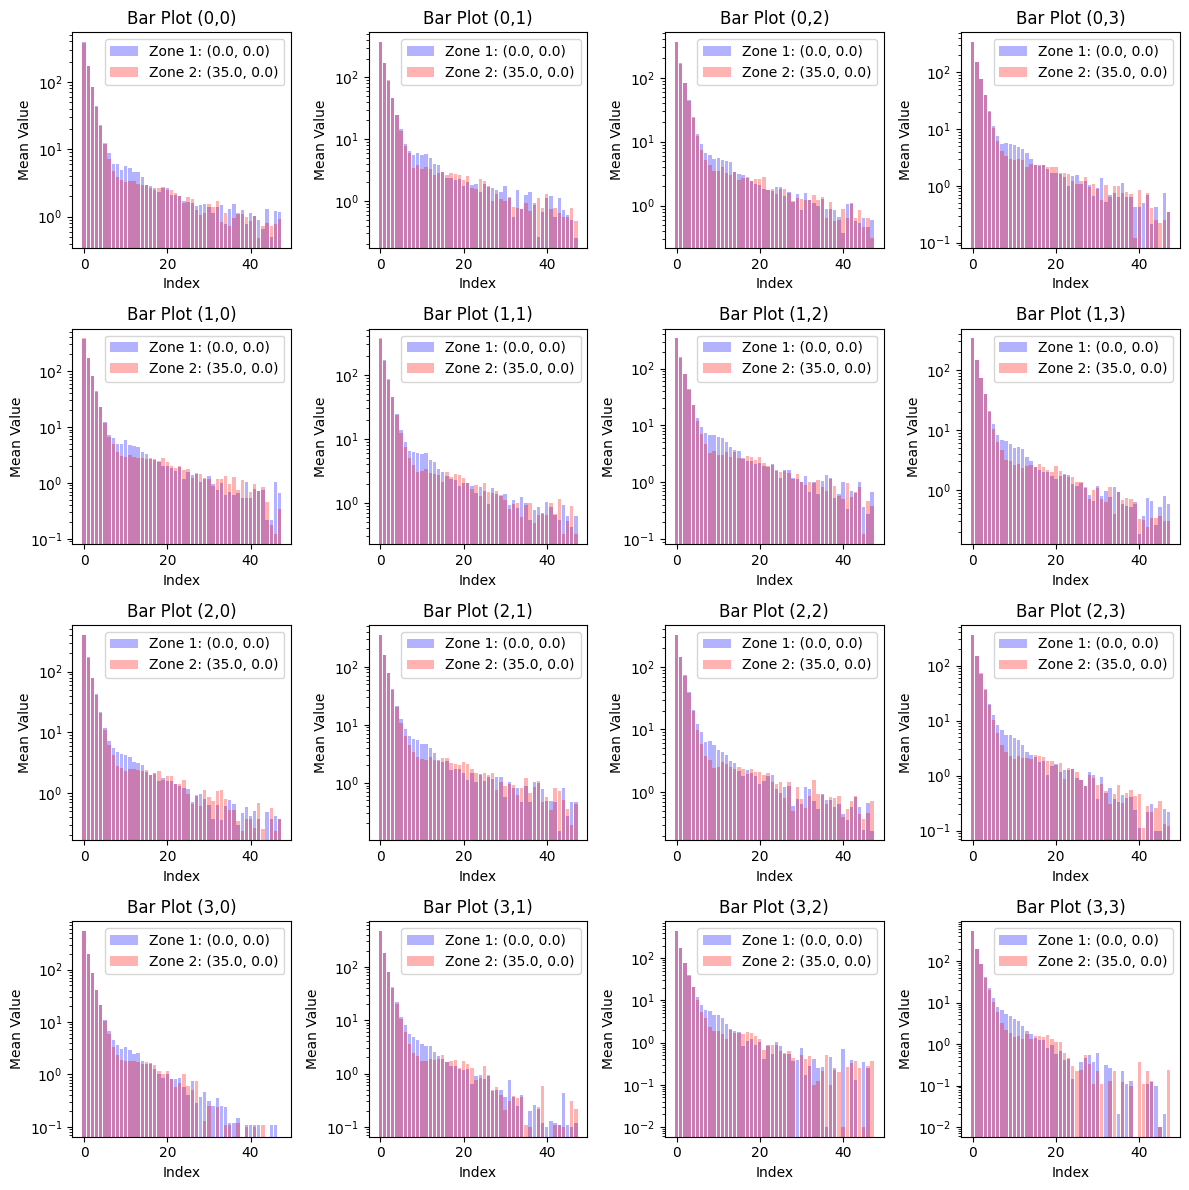

In [ ]:
# Define rectangular bounds: (x_min, x_max, y_min, y_max)
x_min_1, x_max_1 = -0.5, 0.5
y_min_1, y_max_1 = -0.5, 0.5

x_min_2, x_max_2 = 34.5, 35.5
y_min_2, y_max_2 = -0.5, 0.5

# Create mask: True where (x, y) is inside the rectangle
mask_1 = (dataset.raw_targets[:, 0] >= x_min_1) & (dataset.raw_targets[:, 0] <= x_max_1) & \
       (dataset.raw_targets[:, 1] >= y_min_1) & (dataset.raw_targets[:, 1] <= y_max_1)

# Create mask: True where (x, y) is inside the rectangle
mask_2 = (dataset.raw_targets[:, 0] >= x_min_2) & (dataset.raw_targets[:, 0] <= x_max_2) & \
       (dataset.raw_targets[:, 1] >= y_min_2) & (dataset.raw_targets[:, 1] <= y_max_2)

# Print some results
print("Mask shape:", mask_1.shape)  # Should be (n,)
print("Number of points inside:", mask_1.sum().item())  # Count of points inside the rectangle

print("Mask shape:", mask_2.shape)  # Should be (n,)
print("Number of points inside:", mask_2.sum().item())  # Count of points inside the rectangle

masked_inputs_1 = dataset.raw_inputs[mask_1]
print("Masked inputs shape:", masked_inputs_1.shape)

masked_inputs_2 = dataset.raw_inputs[mask_2]
print("Masked inputs shape:", masked_inputs_2.shape)

# Compute mean over the first dimension (n)
mean_tensor_1 = masked_inputs_1.mean(dim=0)  # Shape becomes [4, 4, 48]
mean_tensor_2 = masked_inputs_2.mean(dim=0)  # Shape becomes [4, 4, 48]

# Create a 4x4 grid of bar plots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

x = np.arange(48)  # x-axis positions for the 48 bars

for i in range(4):
       for j in range(4):
              axes[i, j].bar(x, mean_tensor_1[i, j].numpy(), color='b', alpha=0.3)
              axes[i, j].bar(x, mean_tensor_2[i, j].numpy(), color='r', alpha=0.3)
              axes[i, j].set_title(f"Bar Plot ({i},{j})")
              axes[i, j].set_xlabel("Index")
              axes[i, j].set_ylabel("Mean Value")
              axes[i, j].set_yscale('log')
              axes[i, j].legend([f"Zone 1: ({(x_min_1 + x_max_1) / 2}, {(y_min_1 + y_max_1) / 2})",
                            f"Zone 2: ({(x_min_2 + x_max_2) / 2}, {(y_min_2 + y_max_2) / 2})"])

plt.tight_layout()
plt.show()

Mask shape: torch.Size([1000])
Number of points inside: 10
Mask shape: torch.Size([1000])
Number of points inside: 10
Masked inputs shape: torch.Size([10, 4, 4, 48])
Masked inputs shape: torch.Size([10, 4, 4, 48])


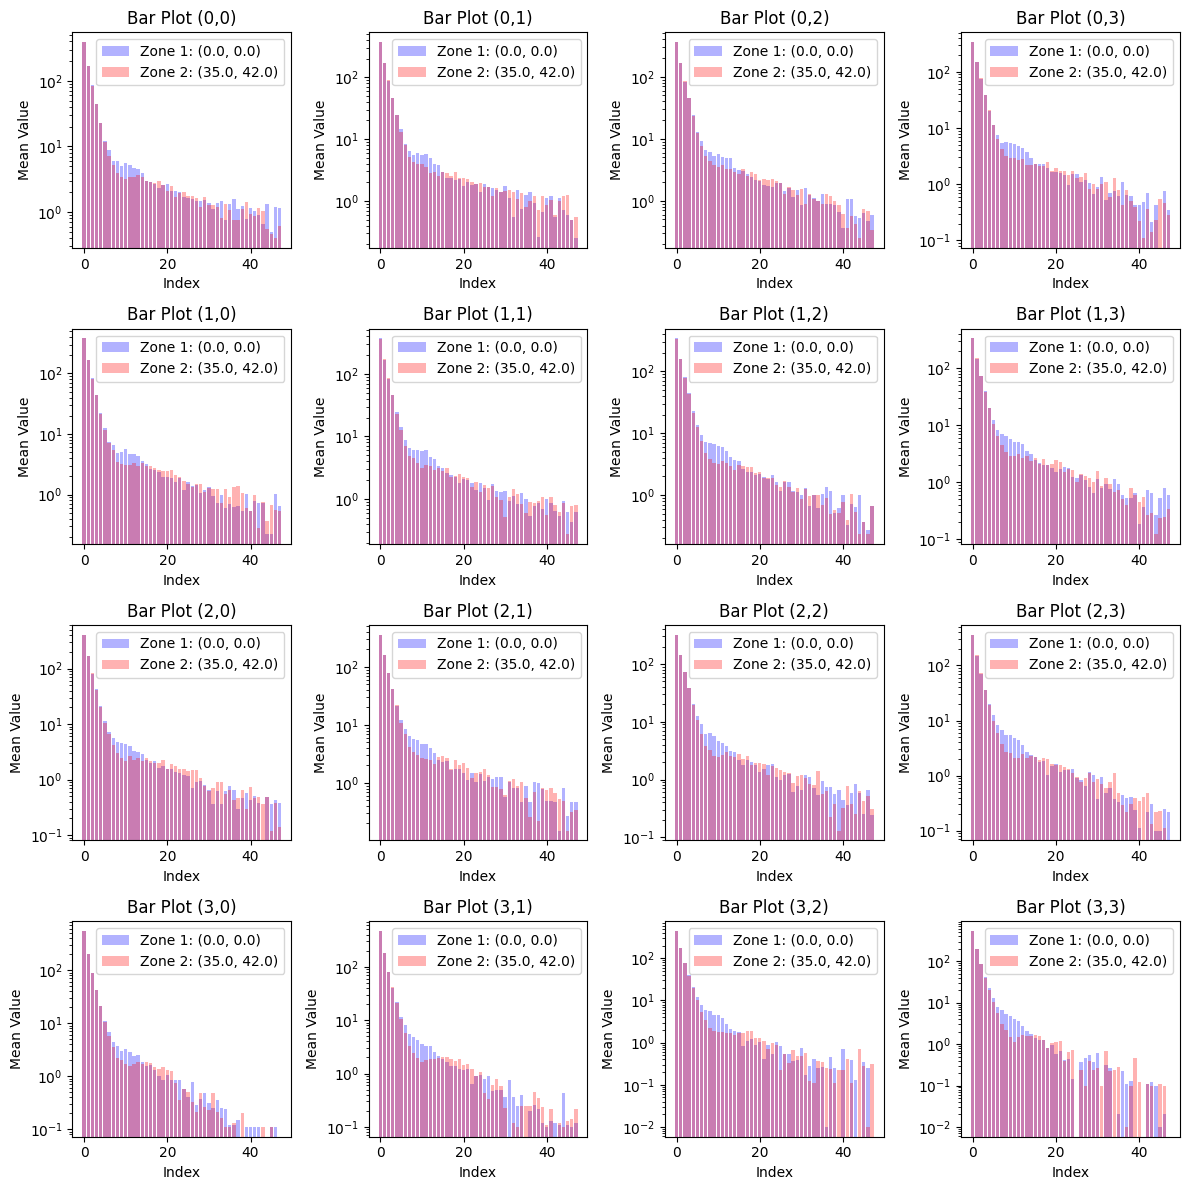

In [96]:
# Define rectangular bounds: (x_min, x_max, y_min, y_max)
x_min_1, x_max_1 = -0.5, 0.5
y_min_1, y_max_1 = -0.5, 0.5

x_min_2, x_max_2 = 34.5, 35.5
y_min_2, y_max_2 = 41.5, 42.5

# Create mask: True where (x, y) is inside the rectangle
mask_1 = (dataset.raw_targets[:, 0] >= x_min_1) & (dataset.raw_targets[:, 0] <= x_max_1) & \
       (dataset.raw_targets[:, 1] >= y_min_1) & (dataset.raw_targets[:, 1] <= y_max_1)

# Create mask: True where (x, y) is inside the rectangle
mask_2 = (dataset.raw_targets[:, 0] >= x_min_2) & (dataset.raw_targets[:, 0] <= x_max_2) & \
       (dataset.raw_targets[:, 1] >= y_min_2) & (dataset.raw_targets[:, 1] <= y_max_2)

# Print some results
print("Mask shape:", mask_1.shape)  # Should be (n,)
print("Number of points inside:", mask_1.sum().item())  # Count of points inside the rectangle

print("Mask shape:", mask_2.shape)  # Should be (n,)
print("Number of points inside:", mask_2.sum().item())  # Count of points inside the rectangle

masked_inputs_1 = dataset.raw_inputs[mask_1]
print("Masked inputs shape:", masked_inputs_1.shape)

masked_inputs_2 = dataset.raw_inputs[mask_2]
print("Masked inputs shape:", masked_inputs_2.shape)

# Compute mean over the first dimension (n)
mean_tensor_1 = masked_inputs_1.mean(dim=0)  # Shape becomes [4, 4, 48]
mean_tensor_2 = masked_inputs_2.mean(dim=0)  # Shape becomes [4, 4, 48]

# Create a 4x4 grid of bar plots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

x = np.arange(48)  # x-axis positions for the 48 bars

for i in range(4):
    for j in range(4):
       axes[i, j].bar(x, mean_tensor_1[i, j].numpy(), color='b', alpha=0.3)
       axes[i, j].bar(x, mean_tensor_2[i, j].numpy(), color='r', alpha=0.3)
       axes[i, j].set_title(f"Bar Plot ({i},{j})")
       axes[i, j].set_xlabel("Index")
       axes[i, j].set_ylabel("Mean Value")
       axes[i, j].set_yscale('log')
       axes[i, j].legend([f"Zone 1: ({(x_min_1 + x_max_1) / 2}, {(y_min_1 + y_max_1) / 2})",
                     f"Zone 2: ({(x_min_2 + x_max_2) / 2}, {(y_min_2 + y_max_2) / 2})"])

plt.tight_layout()
plt.show()

Mask shape: torch.Size([1000])
Number of points inside: 10
Mask shape: torch.Size([1000])
Number of points inside: 10
Masked inputs shape: torch.Size([10, 4, 4, 48])
Masked inputs shape: torch.Size([10, 4, 4, 48])


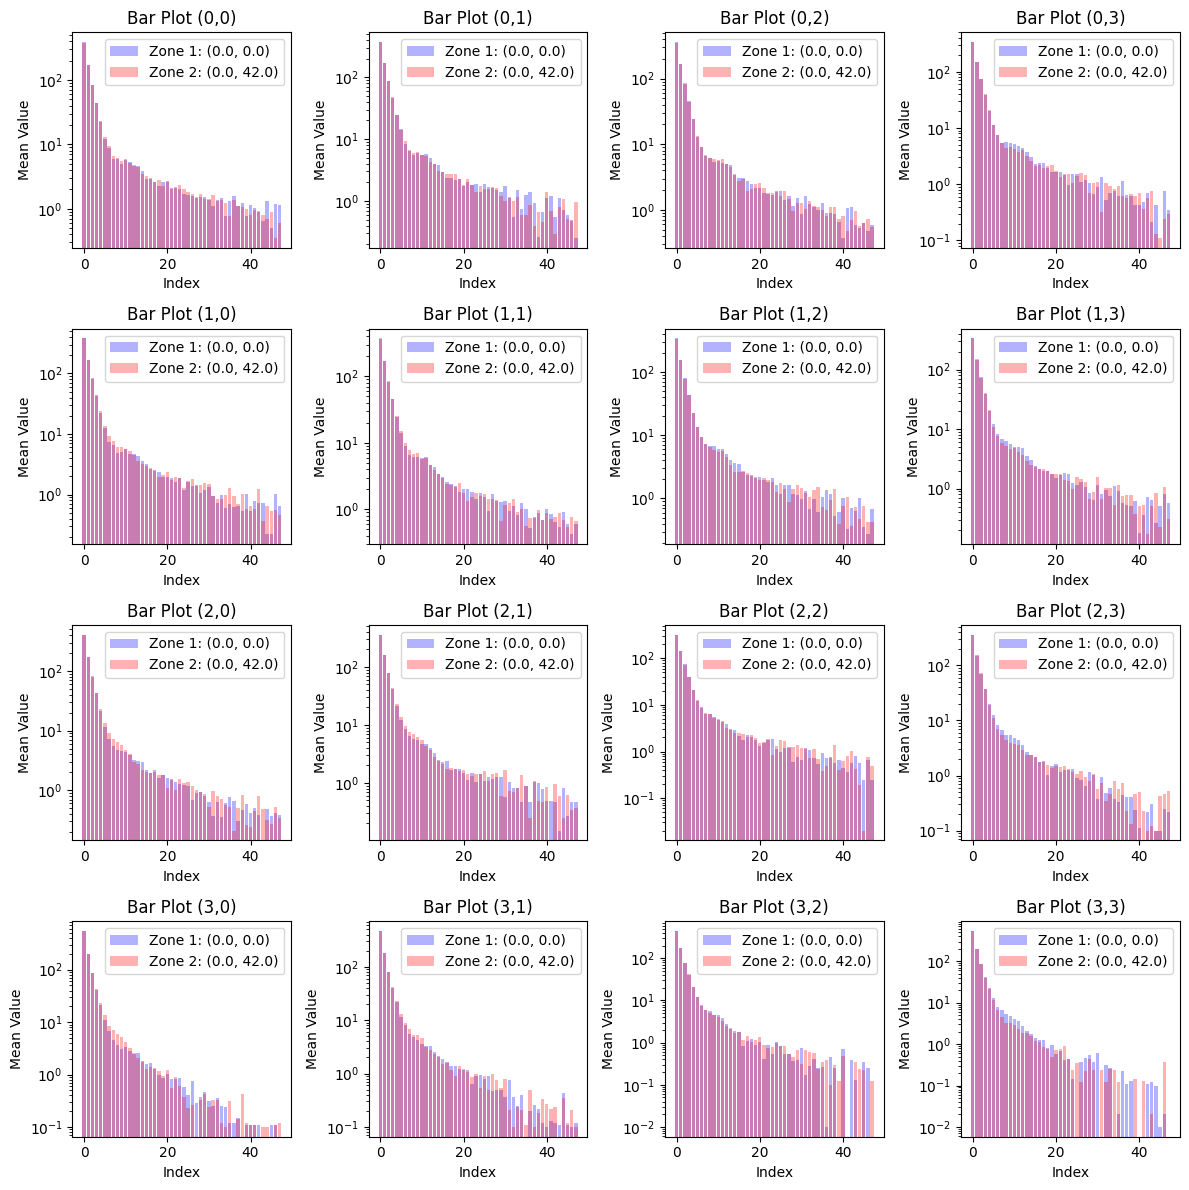

In [97]:
# Define rectangular bounds: (x_min, x_max, y_min, y_max)
x_min_1, x_max_1 = -0.5, 0.5
y_min_1, y_max_1 = -0.5, 0.5

x_min_2, x_max_2 = -0.5, 0.5
y_min_2, y_max_2 = 41.5, 42.5

# Create mask: True where (x, y) is inside the rectangle
mask_1 = (dataset.raw_targets[:, 0] >= x_min_1) & (dataset.raw_targets[:, 0] <= x_max_1) & \
       (dataset.raw_targets[:, 1] >= y_min_1) & (dataset.raw_targets[:, 1] <= y_max_1)

# Create mask: True where (x, y) is inside the rectangle
mask_2 = (dataset.raw_targets[:, 0] >= x_min_2) & (dataset.raw_targets[:, 0] <= x_max_2) & \
       (dataset.raw_targets[:, 1] >= y_min_2) & (dataset.raw_targets[:, 1] <= y_max_2)

# Print some results
print("Mask shape:", mask_1.shape)  # Should be (n,)
print("Number of points inside:", mask_1.sum().item())  # Count of points inside the rectangle

print("Mask shape:", mask_2.shape)  # Should be (n,)
print("Number of points inside:", mask_2.sum().item())  # Count of points inside the rectangle

masked_inputs_1 = dataset.raw_inputs[mask_1]
print("Masked inputs shape:", masked_inputs_1.shape)

masked_inputs_2 = dataset.raw_inputs[mask_2]
print("Masked inputs shape:", masked_inputs_2.shape)

# Compute mean over the first dimension (n)
mean_tensor_1 = masked_inputs_1.mean(dim=0)  # Shape becomes [4, 4, 48]
mean_tensor_2 = masked_inputs_2.mean(dim=0)  # Shape becomes [4, 4, 48]

# Create a 4x4 grid of bar plots
fig, axes = plt.subplots(4, 4, figsize=(12, 12))

x = np.arange(48)  # x-axis positions for the 48 bars

for i in range(4):
    for j in range(4):
       axes[i, j].bar(x, mean_tensor_1[i, j].numpy(), color='b', alpha=0.3)
       axes[i, j].bar(x, mean_tensor_2[i, j].numpy(), color='r', alpha=0.3)
       axes[i, j].set_title(f"Bar Plot ({i},{j})")
       axes[i, j].set_xlabel("Index")
       axes[i, j].set_ylabel("Mean Value")
       axes[i, j].set_yscale('log')
       axes[i, j].legend([f"Zone 1: ({(x_min_1 + x_max_1) / 2}, {(y_min_1 + y_max_1) / 2})",
                     f"Zone 2: ({(x_min_2 + x_max_2) / 2}, {(y_min_2 + y_max_2) / 2})"])

plt.tight_layout()
plt.show()